# Interconnection Temperature

In [1]:
# Start by importing the packages we need:
import os
import datetime

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob
from matplotlib import pyplot 
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Set the Directory Structure

In [2]:
# Identify the data input and output directories:
load_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/tell_output/historic/2019/'
eia_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL_Input_Data/inputs/BA_Hourly_Load/CSV_Files/'
temp_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/wrf_tell_counties_output/historic/'
#temp_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/wrf_tell_counties_output/rcp85hotter/'
metadata_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL_Input_Data/tell_raw_data/County_Shapefiles/'
data_output_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/postprocessed/historical_heat_wave/'
image_output_dir =  '/Users/burl878/Documents/IMMM/Images/TELL/Analysis/Historical_Heat_Wave/'


## Make the Map Plot

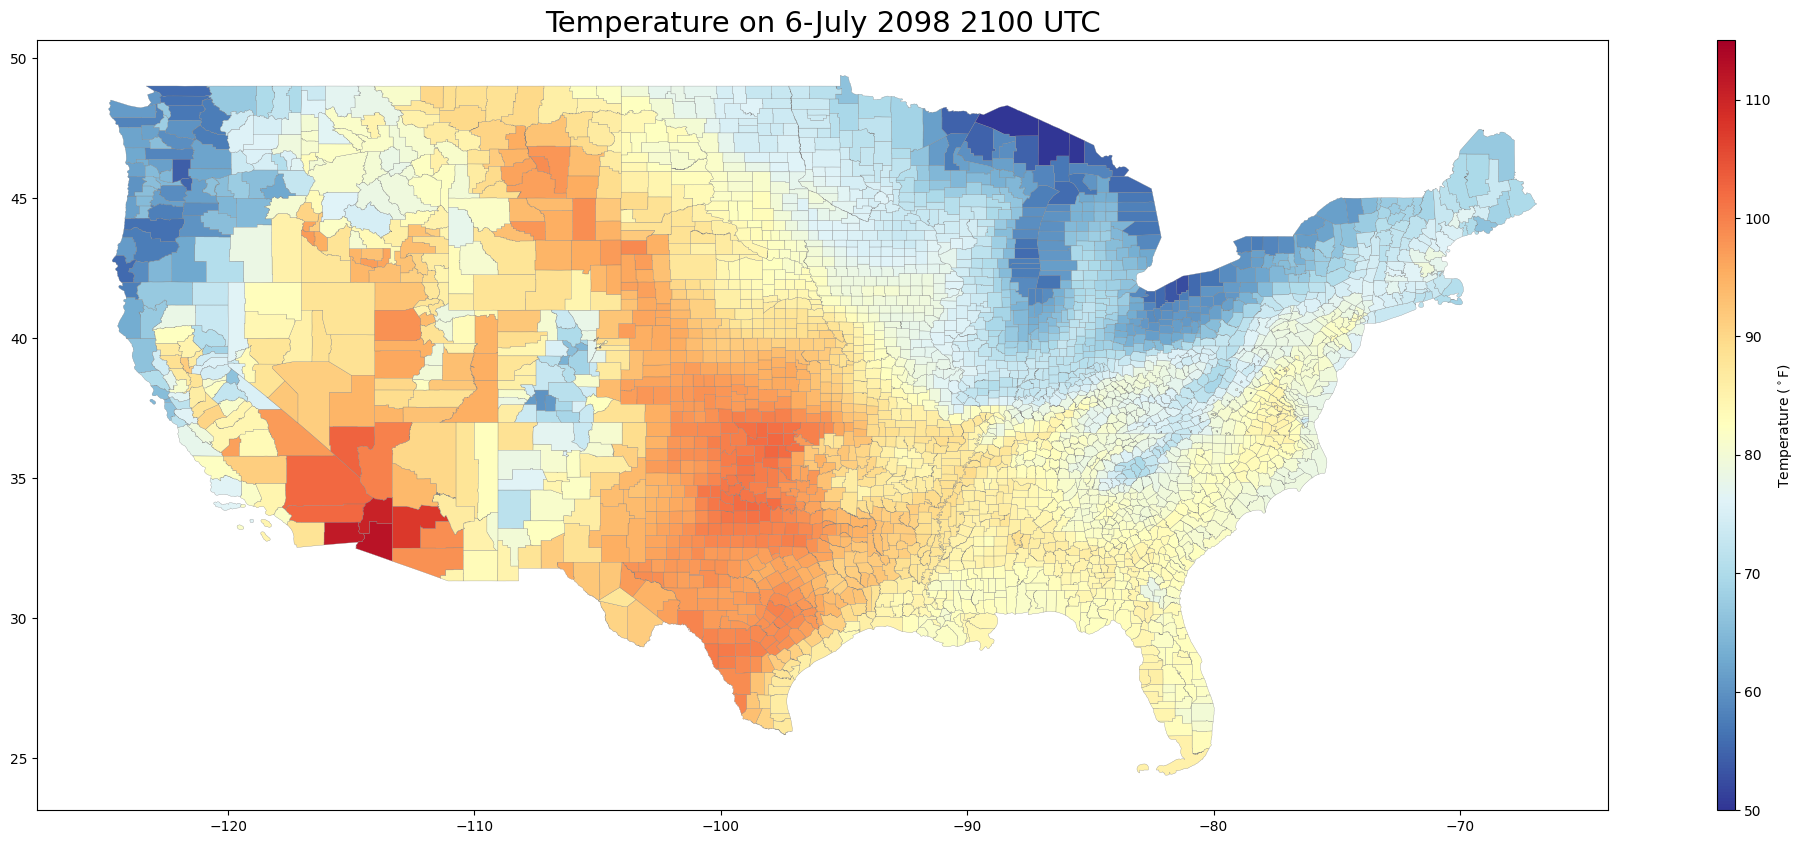

In [3]:
# Read in the county shapefile and reassign the 'FIPS' variable as integers:
counties_df = gpd.read_file(os.path.join(metadata_input_dir, r'tl_2020_us_county.shp')).rename(columns={'GEOID': 'FIPS'})
counties_df['FIPS'] = counties_df['FIPS'].astype(int)

temp_df = pd.read_csv((os.path.join(temp_data_input_dir + '2014/' + '2014_07_24_00_UTC_County_Mean_Meteorology.csv')))
#temp_df = pd.read_csv((os.path.join(temp_data_input_dir + '2018/' + '2018_07_06_21_UTC_County_Mean_Meteorology.csv')))
#temp_df = pd.read_csv((os.path.join(temp_data_input_dir + '2058/' + '2058_07_06_21_UTC_County_Mean_Meteorology.csv')))
#temp_df = pd.read_csv((os.path.join(temp_data_input_dir + '2098/' + '2098_07_06_21_UTC_County_Mean_Meteorology.csv')))
temp_df['T2'] = (1.8 * (temp_df['T2'] - 273)) + 32
       
map_df = counties_df.merge(temp_df, on='FIPS', how='left')
    
# Make the temperature map plot:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.01)
map_df.plot(ax=ax, cax=cax, column='T2', cmap='RdYlBu_r', vmin=50, vmax=115, edgecolor='grey', linewidth=0.2, legend=True, legend_kwds={'label': ('Temperature ($^\circ$F)'), 'orientation': 'vertical'})
#ax.set_title('Temperature on 6-July 2018 2100 UTC', fontsize = 21)
#ax.set_title('Temperature on 6-July 2058 2100 UTC', fontsize = 21)
ax.set_title('Temperature on 6-July 2098 2100 UTC', fontsize = 21)

#filename = ('T2_20180706_2100_UTC.png')
#filename = ('T2_20580706_2100_UTC.png')
filename = ('T2_20980706_2100_UTC.png')
# plt.savefig(os.path.join(image_output_dir, filename), dpi=300, bbox_inches='tight', facecolor='white')


## Make the Time Series Plot

Text(0.5, 1.0, 'Observed Total Load in AZPS: June 2018')

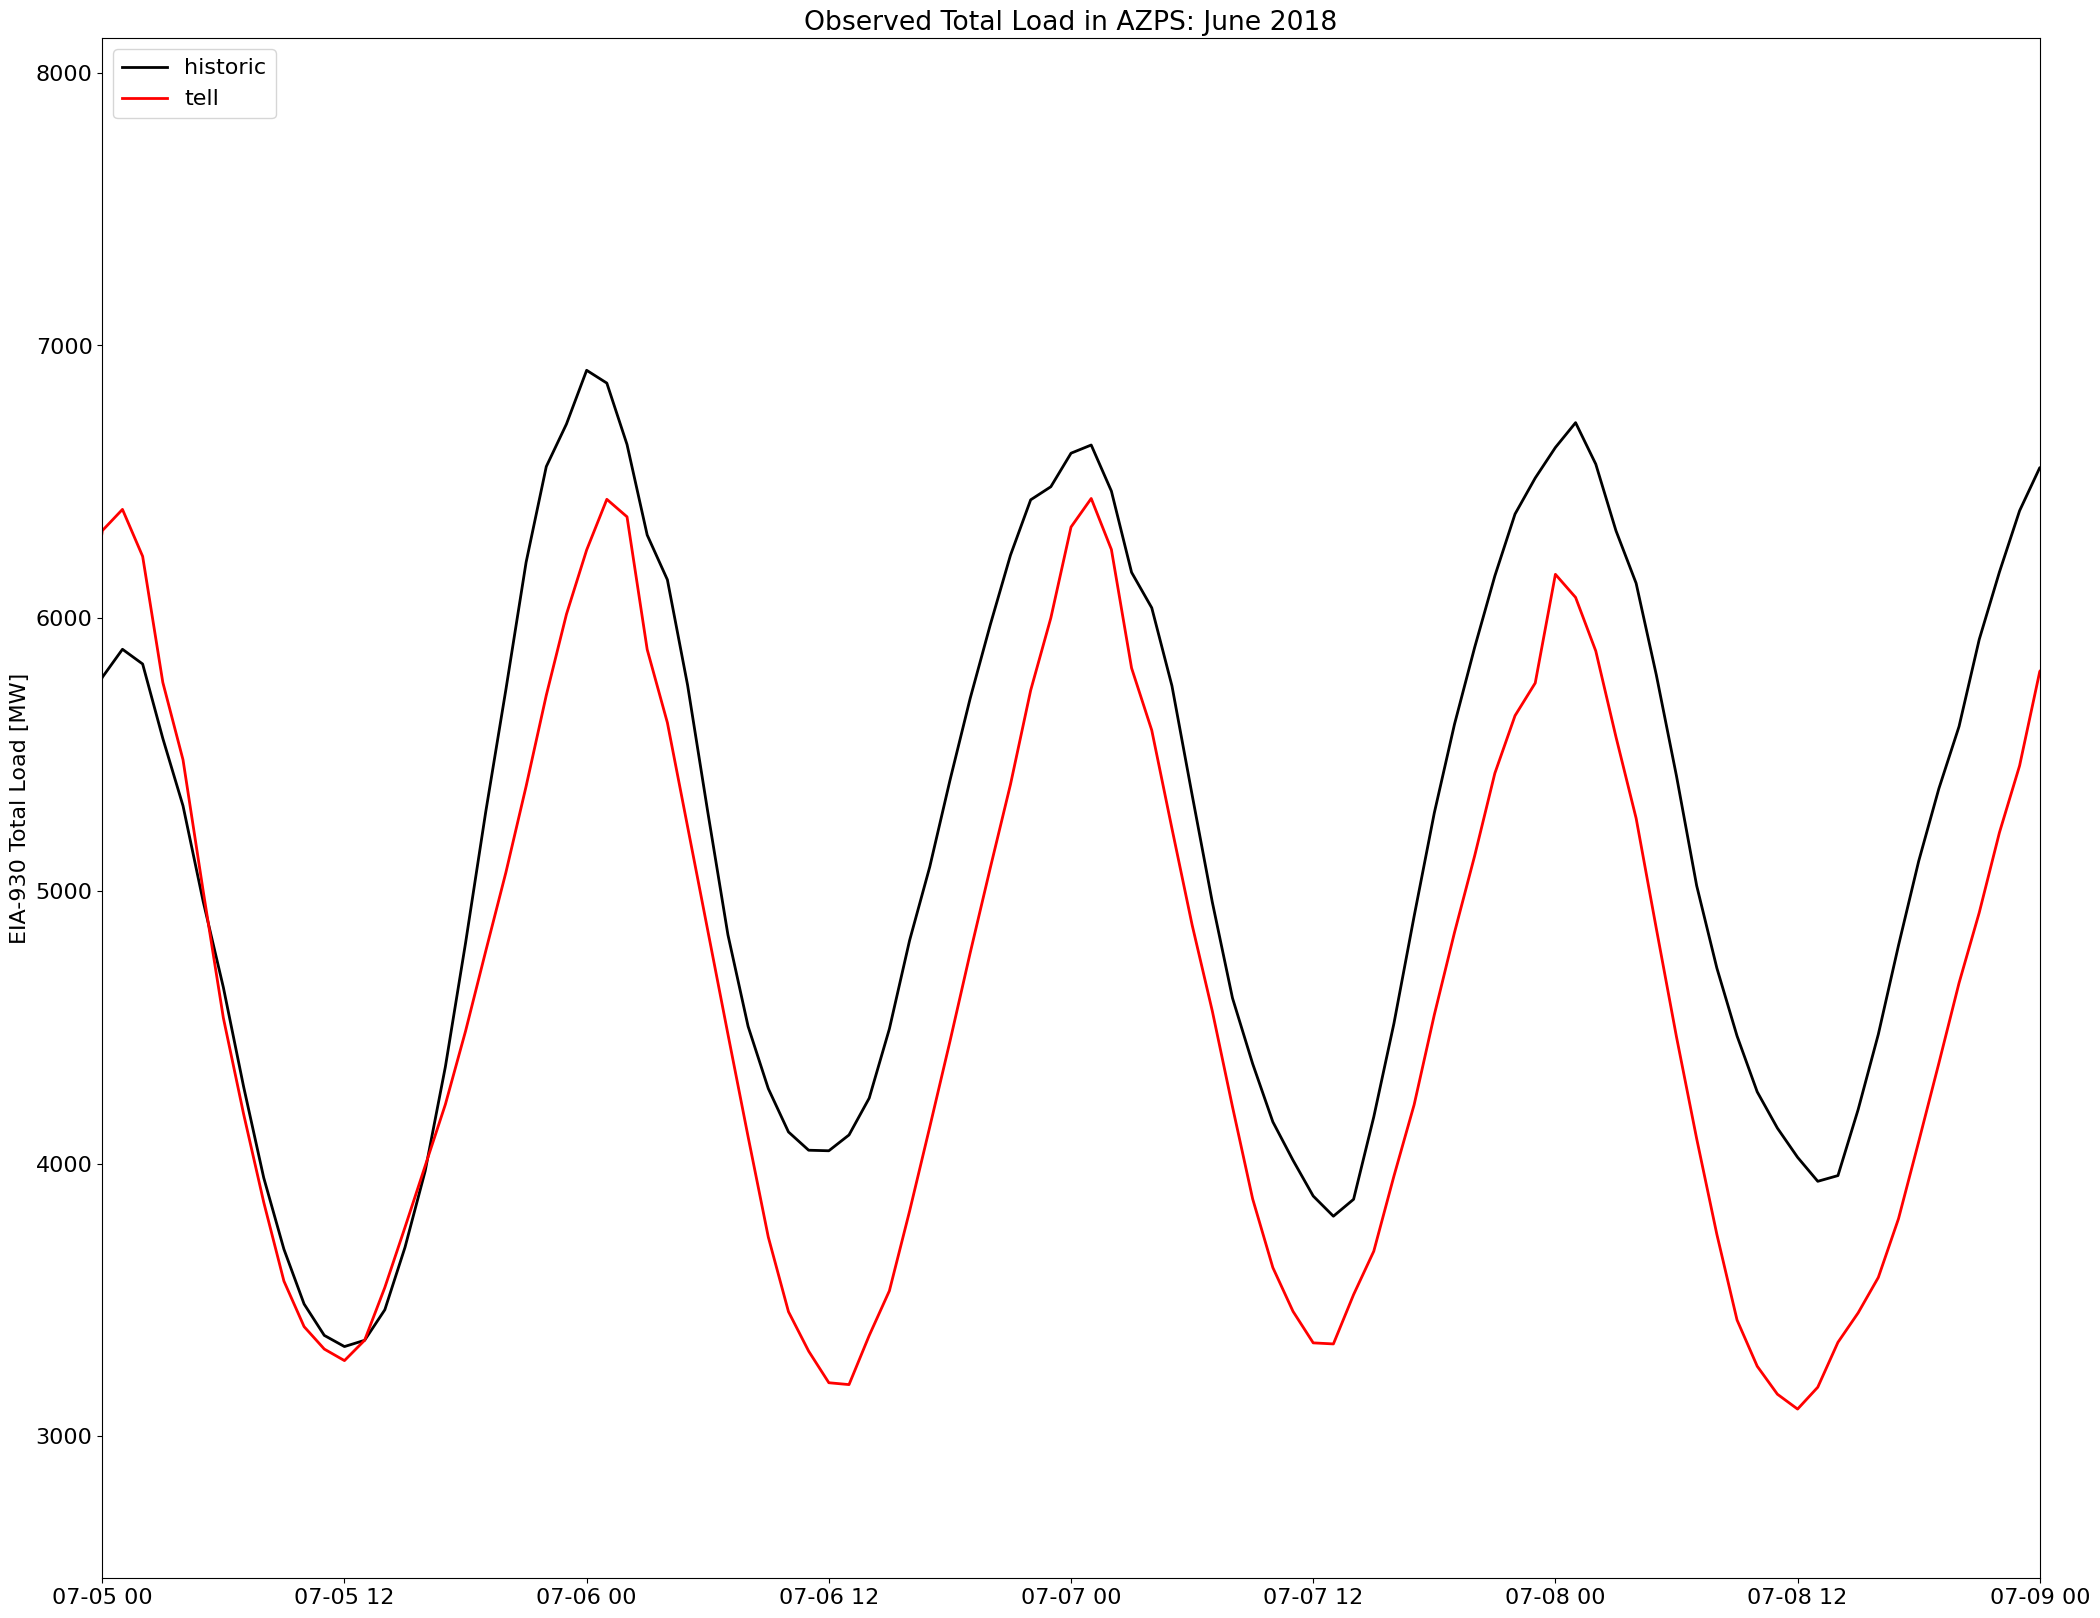

In [44]:
# Give the EIA BA abbreviation for the BA you want to analyze:
ba_to_plot = 'AZPS'

# Read in the historical EIA-930 load data:
historical_df = pd.read_csv((eia_data_input_dir + ba_to_plot + '_Hourly_Load_Data.csv'))

# Rename some columns:
historical_df.rename(columns={'Adjusted_Demand_MWh': 'historic'}, inplace=True)

# Only keep the columns that are needed:
historical_df = historical_df[['Year', 'Month', 'Day', 'Hour', 'historic']].copy()

# Subset to only July of 2018:
historical_df = historical_df.loc[(historical_df['Year'] == 2018) & (historical_df['Month'] == 7)]

# Read in the rcp45cooler_ssp3 load data:
tell_df = pd.read_csv((load_data_input_dir + 'TELL_Balancing_Authority_Hourly_Load_Data_2019_Scaled_2019.csv'))
tell_df = tell_df.loc[tell_df['BA_Code'].isin([ba_to_plot])].copy()
tell_df['Month'] = pd.DatetimeIndex(tell_df['Time_UTC']).month
tell_df['Day'] = pd.DatetimeIndex(tell_df['Time_UTC']).day
tell_df['Hour'] = pd.DatetimeIndex(tell_df['Time_UTC']).hour
tell_df.rename(columns={'Scaled_TELL_BA_Load_MWh': 'tell'}, inplace=True)
tell_df = tell_df[['Month', 'Day', 'Hour', 'tell']].copy()
historical_df = pd.merge(historical_df, tell_df, how='left', on=['Month', 'Day', 'Hour'])

# Convert the time to a datetime variable:
cols=["Year","Month","Day","Hour"]
historical_df['date'] = historical_df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
historical_df['Time_UTC'] = pd.to_datetime(historical_df['date'], format='%Y-%m-%d-%H')

plot_df = historical_df[['Time_UTC','historic', 'tell']].copy()

# Make the plot:
plt.figure(figsize=(25, 20))
plt.rcParams['font.size'] = 16
plt.plot(plot_df['Time_UTC'], plot_df['historic'], color='k', linestyle='-', label='historic', linewidth=2)
plt.plot(plot_df['Time_UTC'], plot_df['tell'], color='r', linestyle='-', label='tell', linewidth=2)
plt.xlim([datetime.date(2018, 7, 5), datetime.date(2018, 7, 9)])
plt.legend(loc='upper left')
plt.xlabel('')
plt.ylabel('EIA-930 Total Load [MW]')
plt.title(('Observed Total Load in ' + ba_to_plot + ': June 2018'))
